# Data Analysis

* Predpokladáme, že trénovacie dáta su stiahnuté a rozbalené v príslušných priečinkoch.
* Nainštalujeme potrebné balíčky

In [2]:
!pip install pyyaml numpy scipy matplotlib ipython jupyter pandas seaborn sympy nose opencv-python opencv-contrib-python imutils

     |████████████████████████████████| 215kB 1.3MB/s eta 0:00:01


In [3]:
import cv2
import scipy.io
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

Nacitame metadata fotiek z wiki_mat

In [4]:
# Loading meta data from Wiki and Imdb datasets.
wiki_mat = scipy.io.loadmat('../data/raw/wiki_crop/wiki.mat')

-----
# Wiki dataset preprocessing

In [5]:
# First examine our data

print("keys:", wiki_mat.keys()) # keys: dict_keys(['__header__', '__version__', '__globals__', 'wiki'])

wiki = wiki_mat['wiki']

print("dtype:", (wiki[0][0]).dtype)

print("L1:", len(wiki))
print("L2:", len(wiki[0]))
print("L3:", len(wiki[0][0]))
print("L4:", len(wiki[0][0][0]))
print("L5:", len(wiki[0][0][0][0]))
print("L6 (data):", wiki[0][0][0][0][0])

keys: dict_keys(['__header__', '__version__', '__globals__', 'wiki'])
dtype: [('dob', 'O'), ('photo_taken', 'O'), ('full_path', 'O'), ('gender', 'O'), ('name', 'O'), ('face_location', 'O'), ('face_score', 'O'), ('second_face_score', 'O')]
L1: 1
L2: 1
L3: 8
L4: 1
L5: 62328
L6 (data): 723671


### Urobime transformaciu z mat datasetu na normalny pandas dataframe.

In [6]:
# Transform to df

columns_n = len(wiki[0][0]) # 8
rows_n = len(wiki[0][0][0][0]) # 62328

columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score"]
data = {}

for j in range(columns_n):
    column = wiki[0][0][j][0]
    data[columns[j]] = column
        
wiki_df = pd.DataFrame(data = data, columns = columns)

In [7]:
# Save memory
wiki = None
data = None

In [8]:
wiki_df.head()

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,[Sami Jauhojärvi],"[[111.29109473290997, 111.29109473290997, 252....",4.300962,NaN
1,703186,1964,[48/10000548_1925-04-04_1964.jpg],1.0,[Dettmar Cramer],"[[252.48330229530742, 126.68165114765371, 354....",2.645639,1.949248
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,[Marc Okrand],"[[113.52, 169.83999999999997, 366.08, 422.4]]",4.329329,NaN
3,705061,1961,[65/10001965_1930-05-23_1961.jpg],1.0,[Aleksandar Matanović],"[[1, 1, 634, 440]]",-inf,NaN
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,[Diana Damrau],"[[171.61031405173117, 75.57451239763239, 266.7...",3.408442,NaN


### Potrebujeme prekonvertovat DOB (data of birth) z matlab formatu do normalneho citatelneho
Zaroven pridame 3 nove polozky do datasetu, a to date of birth a year of birth. Taktiez polozku age, ktora bude  zodpovedat rokom ktore mali v case ked bola pridana fotka.

In [9]:
# Converting matlab specific dt format into python

import datetime as dt

# from: https://stackoverflow.com/a/18277039
def matlab2datetime(matlab_datenum):
    try:
        matlab_datenum=int(matlab_datenum)
        day = dt.datetime.fromordinal(matlab_datenum)
        dayfrac = dt.timedelta(days=matlab_datenum%1) - dt.timedelta(days = 366)
        return day + dayfrac
    except:
        #print("Invalid dob value:", matlab_datenum)
        return None

wiki_df['date_of_birth'] = [matlab2datetime(datenum).date() for datenum in wiki_df['dob']]
wiki_df['year_of_birth'] = [dt.year for dt in wiki_df['date_of_birth']]
wiki_df['age'] = wiki_df['photo_taken'] - wiki_df['year_of_birth']

# Remove dob column. Not needed
wiki_df = wiki_df.drop(['dob'], axis=1)

In [10]:
wiki_df.head()

,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,date_of_birth,year_of_birth,age
0,2009,[17/10000217_1981-05-05_2009.jpg],1.0,[Sami Jauhojärvi],"[[111.29109473290997, 111.29109473290997, 252....",4.300962,NaN,1981-05-05,1981,28
1,1964,[48/10000548_1925-04-04_1964.jpg],1.0,[Dettmar Cramer],"[[252.48330229530742, 126.68165114765371, 354....",2.645639,1.949248,1925-04-04,1925,39
2,2008,[12/100012_1948-07-03_2008.jpg],1.0,[Marc Okrand],"[[113.52, 169.83999999999997, 366.08, 422.4]]",4.329329,NaN,1948-07-03,1948,60
3,1961,[65/10001965_1930-05-23_1961.jpg],1.0,[Aleksandar Matanović],"[[1, 1, 634, 440]]",-inf,NaN,1930-05-23,1930,31
4,2012,[16/10002116_1971-05-31_2012.jpg],0.0,[Diana Damrau],"[[171.61031405173117, 75.57451239763239, 266.7...",3.408442,NaN,1971-05-31,1971,41


### Dalsi spracovanie stlpcov
Ako mozeme vidiet, data z niektorych stlpcoch su v podobe [data]. Potrebujeme spracovat aby boli bez zatvoriek.

In [11]:
def map_names(value):
    if value == None or len(value) == 0:
        return value
    
    return value[0]

In [12]:
wiki_df['full_path'] = wiki_df['full_path'].map(lambda x: x[0])
wiki_df['face_location'] = wiki_df['face_location'].map(lambda x: x[0])
wiki_df['name'] = wiki_df['name'].map(map_names)

/home/viliam/.virtualenvs/neural_networks_at_fiit/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  


In [13]:
wiki_df.head()

,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,date_of_birth,year_of_birth,age
0,2009,17/10000217_1981-05-05_2009.jpg,1.0,Sami Jauhojärvi,"[111.29109473290997, 111.29109473290997, 252.6...",4.300962,NaN,1981-05-05,1981,28
1,1964,48/10000548_1925-04-04_1964.jpg,1.0,Dettmar Cramer,"[252.48330229530742, 126.68165114765371, 354.5...",2.645639,1.949248,1925-04-04,1925,39
2,2008,12/100012_1948-07-03_2008.jpg,1.0,Marc Okrand,"[113.52, 169.83999999999997, 366.08, 422.4]",4.329329,NaN,1948-07-03,1948,60
3,1961,65/10001965_1930-05-23_1961.jpg,1.0,Aleksandar Matanović,"[1, 1, 634, 440]",-inf,NaN,1930-05-23,1930,31
4,2012,16/10002116_1971-05-31_2012.jpg,0.0,Diana Damrau,"[171.61031405173117, 75.57451239763239, 266.76...",3.408442,NaN,1971-05-31,1971,41


### Teras sa mozme pozriet na informacie o datasete.

In [14]:
wiki_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62328 entries, 0 to 62327
Data columns (total 10 columns):
photo_taken          62328 non-null uint16
full_path            62328 non-null object
gender               59685 non-null float64
name                 62328 non-null object
face_location        62328 non-null object
face_score           62328 non-null float64
second_face_score    4096 non-null float64
date_of_birth        62328 non-null object
year_of_birth        62328 non-null int64
age                  62328 non-null int64
dtypes: float64(3), int64(2), object(4), uint16(1)
memory usage: 4.4+ MB


In [15]:
wiki_df.describe()

,photo_taken,gender,face_score,second_face_score,year_of_birth,age
count,62328.000000,59685.000000,6.232800e+04,4096.000000,62328.000000,62328.000000
mean,1998.765627,0.788523,-inf,2.009050,1961.712376,37.053251
std,20.907937,0.408359,NaN,0.981277,29.661020,23.870392
min,1940.000000,0.000000,-inf,0.731419,11.000000,-74.000000
25%,1992.750000,1.000000,-inf,1.164925,1945.000000,24.000000
50%,2009.000000,1.000000,2.463949e+00,1.839065,1969.000000,31.000000
75%,2012.000000,1.000000,3.760014e+00,2.655757,1984.000000,47.000000
max,2015.000000,1.000000,7.081268e+00,5.463147,2015.000000,1996.000000


In [16]:
print("Number of rows:", len(wiki_df))

Number of rows: 62328


## Wiki dataset, attributes analysis

### Atribut: 'age'

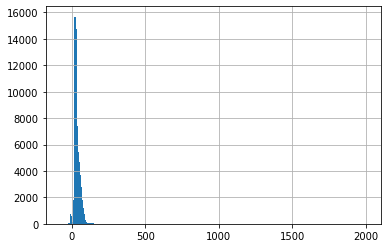

In [17]:
histogram_age = wiki_df['age'].hist(bins=wiki_df['age'].nunique())

Vidime ze je mozne ze sa nachadzaju vychilene hodnoty v datasete. Preto si vytvorime boxplot aby sme mali presnejsi prehlad.

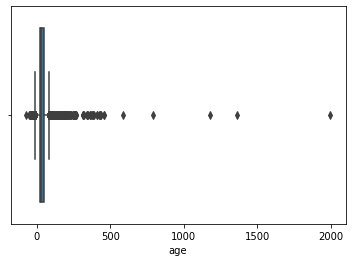

In [18]:
sns.boxplot('age', data=wiki_df)

### Atribut: 'gender'

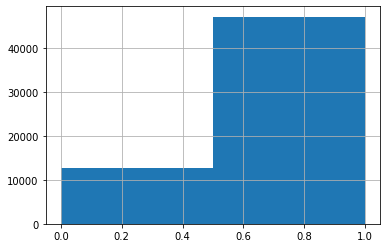

In [19]:
histogram_gender = wiki_df['gender'].hist(bins=wiki_df['gender'].nunique())

- 0 corresponds to female.
- 1 corresponds to male.

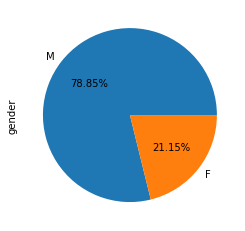

In [20]:
wiki_df['gender'].value_counts().plot.pie(labels=['M', 'F'], autopct='%.2f%%')

### Atribut: 'photo_taken'

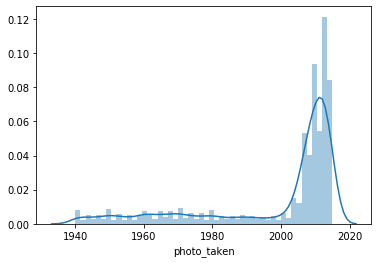

In [21]:
sns.distplot(wiki_df['photo_taken'])

Vidime ze fotky boli urobene od roku 1930 do 2000, a vacsina od 2000 do 2019.

### Plot correlation between attributes

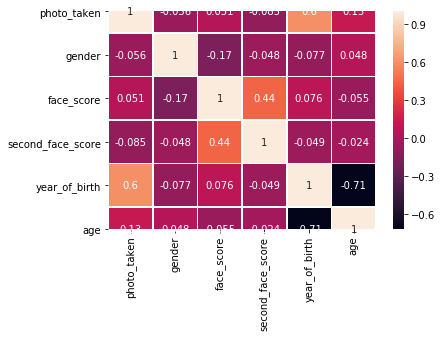

In [22]:
sns.heatmap(wiki_df.corr(), annot=True, linewidths=.5)

Heatmapa korelacii atributov. Cim blizsie k hodnoty 1, tym lepsie koreluju dva prvky.

## Filter data
Niektore hodnoty potrebujeme z datasetu vymazat. Napriklad podla atribut face_score vieme zistit ci sa nejaka tvar nachadza vo fotky alebo nie. V pripade ze nie, fotku vymazeme.
1. nastavime kriteria
2. vypocitame pre kazdy riadok
  - face_score nie je -Inf
  - obsahuje iba jednu tvar
  - face confidence je vacsia ako 3
  - pre trenovanie veku
    - vek je medzi 1 az 100
  - pre trenovanie pohlavia
    - pohlavie nie je NaN
3. vymazeme nevhodne riadky

In [23]:
def has_valid_row(row):
    if row['face_score'] == -np.inf:
        return False
    if row['face_score'] < 3:
        return False
    if isinstance(row['second_face_score'], (int, float)) == True and row['second_face_score'] > 0:
        return False
    return True

def has_valid_age(row):
    if has_valid_row(row) == False:
        return False
    if row['age'] <= 0:
        return False
    if row['age'] > 100:
        return False
    
    return True

def has_valid_gender(row):
    if has_valid_row(row) == False:
        return False
    if isinstance(row['gender'], (int, float)) == False:
        return False

    return True

In [24]:
wiki_df['has_valid_age'] = wiki_df.apply(has_valid_age, axis=1)
wiki_df['has_valid_gender'] = wiki_df.apply(has_valid_gender, axis=1)

In [25]:
wiki_df.head()

,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,date_of_birth,year_of_birth,age,has_valid_age,has_valid_gender
0,2009,17/10000217_1981-05-05_2009.jpg,1.0,Sami Jauhojärvi,"[111.29109473290997, 111.29109473290997, 252.6...",4.300962,NaN,1981-05-05,1981,28,True,True
1,1964,48/10000548_1925-04-04_1964.jpg,1.0,Dettmar Cramer,"[252.48330229530742, 126.68165114765371, 354.5...",2.645639,1.949248,1925-04-04,1925,39,False,False
2,2008,12/100012_1948-07-03_2008.jpg,1.0,Marc Okrand,"[113.52, 169.83999999999997, 366.08, 422.4]",4.329329,NaN,1948-07-03,1948,60,True,True
3,1961,65/10001965_1930-05-23_1961.jpg,1.0,Aleksandar Matanović,"[1, 1, 634, 440]",-inf,NaN,1930-05-23,1930,31,False,False
4,2012,16/10002116_1971-05-31_2012.jpg,0.0,Diana Damrau,"[171.61031405173117, 75.57451239763239, 266.76...",3.408442,NaN,1971-05-31,1971,41,True,True


## Ulozime si vytvoreny dataframe.

In [26]:
# Save data set to python format

wiki_df.to_pickle('../data/processed/wiki_meta_df.pkl')

In [27]:
# age_wiki_df will have only rows with True in has_valid_age
age_wiki_df = wiki_df[wiki_df['has_valid_age'] == True]
age_wiki_df.reset_index(drop=True,inplace=True)

# gender_wiki_df will have only rows with True in has_valid_gender
gender_wiki_df = wiki_df[wiki_df['has_valid_gender'] == True]
gender_wiki_df.reset_index(drop=True,inplace=True)

## Ploty na porovnanie distribucie zvysnych dat, s ktorymi budeme trenovat model.

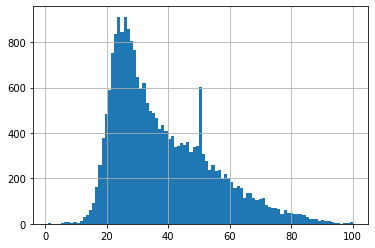

In [28]:
histogram_age = age_wiki_df['age'].hist(bins=age_wiki_df['age'].nunique())

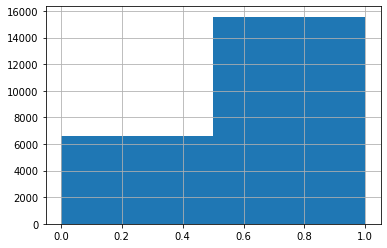

In [29]:
histogram_gender = gender_wiki_df['gender'].hist(bins=gender_wiki_df['gender'].nunique())

Pozrieme sa na rozdiel medzi povodnymi datami a tymi ktore zostali.

In [30]:
print("Intial data size: " + str(len(wiki_df)))
print("Left age data size: " + str(len(age_wiki_df)))
print("Left gender data size: " + str(len(gender_wiki_df)))
print("Dataset with gender and age valid fields: " + str(len(wiki_df[(wiki_df['has_valid_age'] & wiki_df['has_valid_gender'])])))

Intial data size: 62328
Left age data size: 22578
Left gender data size: 22596
Dataset with gender and age valid fields: 22578


## Ulozime si dataframe s atributmi ktore budeme iba potrebovat.

In [31]:
wiki_df.head()

,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,date_of_birth,year_of_birth,age,has_valid_age,has_valid_gender
0,2009,17/10000217_1981-05-05_2009.jpg,1.0,Sami Jauhojärvi,"[111.29109473290997, 111.29109473290997, 252.6...",4.300962,NaN,1981-05-05,1981,28,True,True
1,1964,48/10000548_1925-04-04_1964.jpg,1.0,Dettmar Cramer,"[252.48330229530742, 126.68165114765371, 354.5...",2.645639,1.949248,1925-04-04,1925,39,False,False
2,2008,12/100012_1948-07-03_2008.jpg,1.0,Marc Okrand,"[113.52, 169.83999999999997, 366.08, 422.4]",4.329329,NaN,1948-07-03,1948,60,True,True
3,1961,65/10001965_1930-05-23_1961.jpg,1.0,Aleksandar Matanović,"[1, 1, 634, 440]",-inf,NaN,1930-05-23,1930,31,False,False
4,2012,16/10002116_1971-05-31_2012.jpg,0.0,Diana Damrau,"[171.61031405173117, 75.57451239763239, 266.76...",3.408442,NaN,1971-05-31,1971,41,True,True


Nechame atributy 'full_path', 'gender', 'age'. 

In [32]:
pp_wiki_df = wiki_df[(wiki_df['has_valid_age'] & wiki_df['has_valid_gender'])].loc[:, ['full_path', 'gender', 'age']]
pp_wiki_df.head()

,full_path,gender,age
0,17/10000217_1981-05-05_2009.jpg,1.0,28
2,12/100012_1948-07-03_2008.jpg,1.0,60
4,16/10002116_1971-05-31_2012.jpg,0.0,41
5,02/10002702_1960-11-09_2012.jpg,0.0,52
6,41/10003541_1937-09-27_1971.jpg,1.0,34


Vidime ze pri vytvoreni dataframeu, ostali zle indexi. Preto potrebujeme dataframe reindexovat.

In [33]:
pp_wiki_df = pp_wiki_df.reset_index().drop(['index'], axis=1)
pp_wiki_df.head()

,full_path,gender,age
0,17/10000217_1981-05-05_2009.jpg,1.0,28
1,12/100012_1948-07-03_2008.jpg,1.0,60
2,16/10002116_1971-05-31_2012.jpg,0.0,41
3,02/10002702_1960-11-09_2012.jpg,0.0,52
4,41/10003541_1937-09-27_1971.jpg,1.0,34


Zaroven nacitame a ulozime pixeli fotky do dataframeu, a ulozime iba dataframe z polozkami ktore maju obydve atributy vyplnene.

In [34]:
import cv2

In [35]:
pp_wiki_df['img_array'] = pp_wiki_df['full_path'].apply(lambda x: np.array(cv2.resize(cv2.imread('../data/raw/wiki_crop/' + x), (224, 224), interpolation=cv2.INTER_LINEAR).reshape(1, -1)[0]))

Ulozime dataframe.

In [36]:
print("Dlzka dataframeu: " + str(len(pp_wiki_df)))
pp_wiki_df.to_csv('../data/processed/wiki_df.csv', sep = ';', index=False)

Dlzka dataframeu: 22578


### Ukazka fotiek ludi z datasetu.

Populating the interactive namespace from numpy and matplotlib


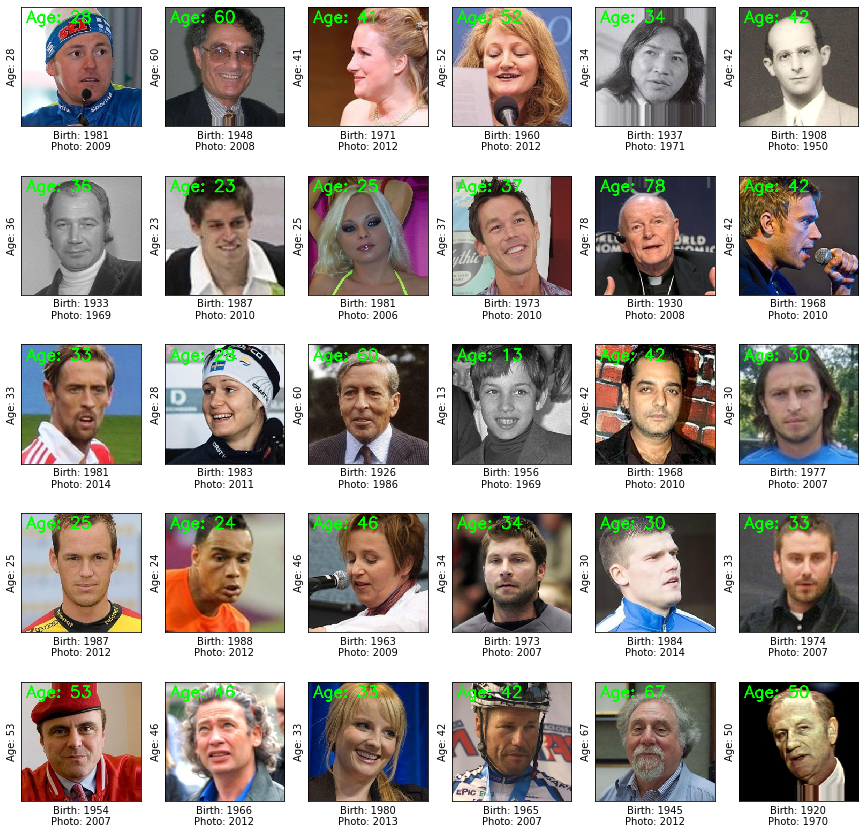

In [52]:
%pylab inline

font = cv2.FONT_HERSHEY_SIMPLEX
plt.figure(figsize=(15,15))

for i in range(30):
    plt.subplot(5, 6, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    age = 'Age: ' + str(age_wiki_df['age'][i])
    image_path = '../data/raw/wiki_crop/' + str(age_wiki_df['full_path'][i])
    
    im = cv2.imread(image_path)
    im_resized = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)
    
    cv2.putText(im_resized, age, (10,30), font, 1, (0, 255, 0), 2, cv2.LINE_AA)

    plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB), cmap=plt.cm.binary)

    plt.ylabel(age)
    label = "" # age + "\n"
    label = label + "Birth: " + str(age_wiki_df['year_of_birth'][i])
    label = label + "\nPhoto: " + str(age_wiki_df['photo_taken'][i])
    plt.xlabel(label)

plt.show()

**TODOS:**

### Expand data set
- opencv rotation
- opencv scale
- opencv blur, noise, ...

## Load data for traing
- ???

In [53]:
from scipy import ndimage

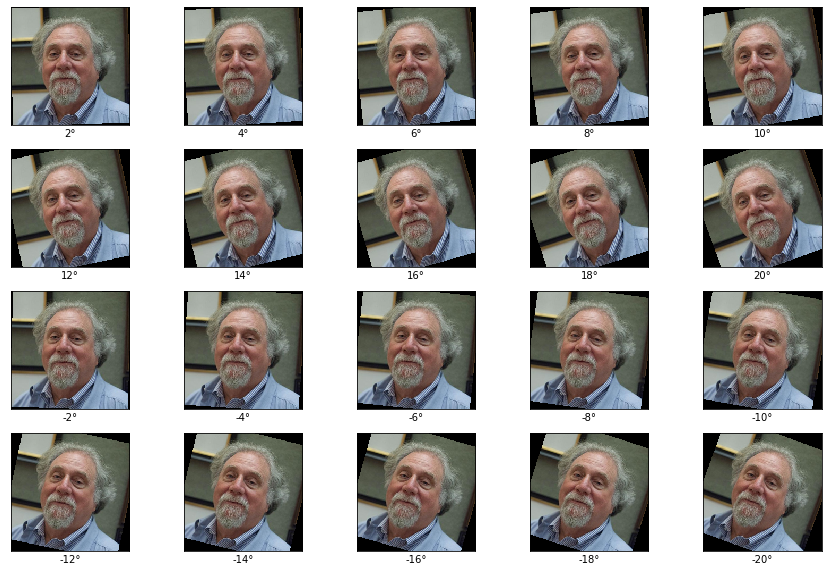

In [73]:
plt.figure(figsize=(15,10))

for i in range(10):
    image_path = '../data/raw/wiki_crop/' + str(age_wiki_df['full_path'][28])
    im = cv2.imread(image_path)
    im_resized = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)
    im_converted = cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB)
    
    # Rotation degree
    d = (i+1)*2
    
    plt.subplot(4, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    rotated = ndimage.rotate(im_converted, d, reshape=False)
    plt.xlabel(str(d) + "°")
    
    plt.imshow(rotated, cmap=plt.cm.binary)
    
    plt.subplot(4, 5, i+10+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    rotated = ndimage.rotate(im_converted, -d, reshape=False)
    plt.xlabel(str(-d) + "°")
    
    plt.imshow(rotated, cmap=plt.cm.binary)

plt.show()

In [74]:
#From https://stackoverflow.com/a/37121993
def clipped_zoom(img, zoom_factor, **kwargs):

    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = ndimage.zoom(img, zoom_tuple, **kwargs)

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = ndimage.zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

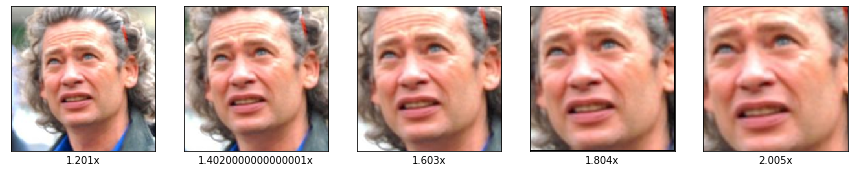

In [84]:
plt.figure(figsize=(15,10))

for i in range(5):
    image_path = '../data/raw/wiki_crop/' + str(age_wiki_df['full_path'][25])
    im = cv2.imread(image_path)
    im_resized = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)
    im_converted = cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB)
    
    # Zoom factor
    z = 1 + (i+1)*0.201 # Bug for 0.2 and for 0.2001, 0.20001, ...
    
    plt.subplot(1, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    zoomed = clipped_zoom(im_converted, z)
    plt.xlabel(str(z) + "x")
    
    plt.imshow(zoomed, cmap=plt.cm.binary)

plt.show()

In [85]:
# from: http://www.xiaoliangbai.com/2016/09/09/more-on-image-noise-generation
def noise_generator (noise_type,image):
    """
    Generate noise to a given Image based on required noise type
    
    Input parameters:
        image: ndarray (input image data. It will be converted to float)
        
        noise_type: string
            'gauss'        Gaussian-distrituion based noise
            'poission'     Poission-distribution based noise
            's&p'          Salt and Pepper noise, 0 or 1
            'speckle'      Multiplicative noise using out = image + n*image
                           where n is uniform noise with specified mean & variance
    """
    row,col,ch= image.shape
    if noise_type == "gauss":       
        mean = 0.0
        var = 0.01
        sigma = var**0.5
        gauss = np.array(image.shape)
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy.astype('uint8')
    elif noise_type == "s&p":
        s_vs_p = 0.5
        amount = 0.004
        out = image
        # Generate Salt '1' noise
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 255
        # Generate Pepper '0' noise
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        return out
    elif noise_type == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_type =="speckle":
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy
    else:
        return image
    

/home/viliam/.virtualenvs/neural_networks_at_fiit/lib/python3.6/site-packages/ipykernel_launcher.py:34: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/viliam/.virtualenvs/neural_networks_at_fiit/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


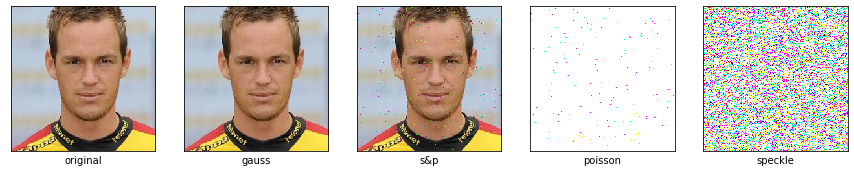

In [94]:
IMAGE_ID = 18

# Open image
image_path = '../data/raw/wiki_crop/' + str(age_wiki_df['full_path'][IMAGE_ID])
im = cv2.imread(image_path)
im_resized = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)
im_converted = cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,10))

filters = ['original', 'gauss', 's&p', 'poisson', 'speckle']

for i, filter_name in zip(range(5), filters):
    plt.subplot(1, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    noised = noise_generator(filter_name, im_converted)
    plt.xlabel(filter_name)
    
    plt.imshow(noised, cmap=plt.cm.binary)

plt.show()

## Imdb dataset analysis

- **TODO:** Same action as with wiki datasets

In [90]:
imdb_mat = scipy.io.loadmat('../data/raw/imdb_crop/imdb.mat')

In [ ]:
print("keys:", imdb_mat.keys()) # keys: dict_keys(['__header__', '__version__', '__globals__', 'imdb'])

imdb = imdb_mat['imdb']

print("dtype:", (imdb[0][0]).dtype)

print("L1:", len(imdb))
print("L2:", len(imdb[0]))
print("L3:", len(imdb[0][0]))
print("L4:", len(imdb[0][0][0]))
print("L5:", len(imdb[0][0][0][0]))
print("L6 (data):", imdb[0][0][0][0][0])

In [ ]:
for j in range(columns_n):
    print(len(imdb[0][0][j][0]))

In [ ]:
#for x in range(20284, 460724):
#    imdb[0][0][8][0][x] = None
#
#print(len(imdb[0][0][8][0]))

In [ ]:
# Transform to df

columns_n = len(imdb[0][0]) # 10
rows_n = len(imdb[0][0][0][0]) # 460723
columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score", "celeb_names", "celeb_id"]

imdb_df = None

for i in range(1):
    data = {}
    for j in range(columns_n):
        column = imdb[0][0][j][0]
        data[columns[j]] = column
        if j == 8:
            n = np.zeros(440439)
            data[columns[j]] = np.concatenate((column, n))
            continue # skip 8th column. 

    imdb_df = pd.DataFrame(data = data, columns = columns)

#column8 = imdb[0][0][8][0]
#df2 = pd.DataFrame(index = range(rows_n), columns = ['celeb_names'])
#for x in range(len(imdb[0][0][8][0])):
    #df2['celeb_names'][x] = pd.DataFrame(imdb[0][0][8][0][x])
    #imdb_df['celeb_names'][x] = str(imdb[0][0][8][0][x][0])

#df3 = pd.DataFrame(data = column8, columns = ['celeb_names'])
#df2.append(df3, ignore_index = True)
#imdb_df.append(df2)

In [ ]:
imdb_df['date_of_birth'] = [matlab2datetime(datenum) for datenum in imdb_df['dob']] # For invalid dt None is returned
imdb_df['year_of_birth'] = [dt.year for dt in imdb_df['date_of_birth']]
imdb_df['age'] = imdb_df['photo_taken'] - imdb_df['year_of_birth']

In [ ]:

# Identifies invalid values - about 129 rows
imdb_df[ imdb_df['date_of_birth'].isna() ]


In [ ]:
imdb_df

In [ ]:
imdb_df.describe()

In [ ]:
imdb_df.to_pickle('../data/processed/imdb_meta_df.pkl')

TODO
- otvorit meta data
- konvertovat do py
- ...

## Reference

todo